In [2]:
from pathlib import Path
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1)
sns.set_palette("colorblind")

nvalloc = Path("write/220930-105120")
buddy = Path("write/220930-104515")


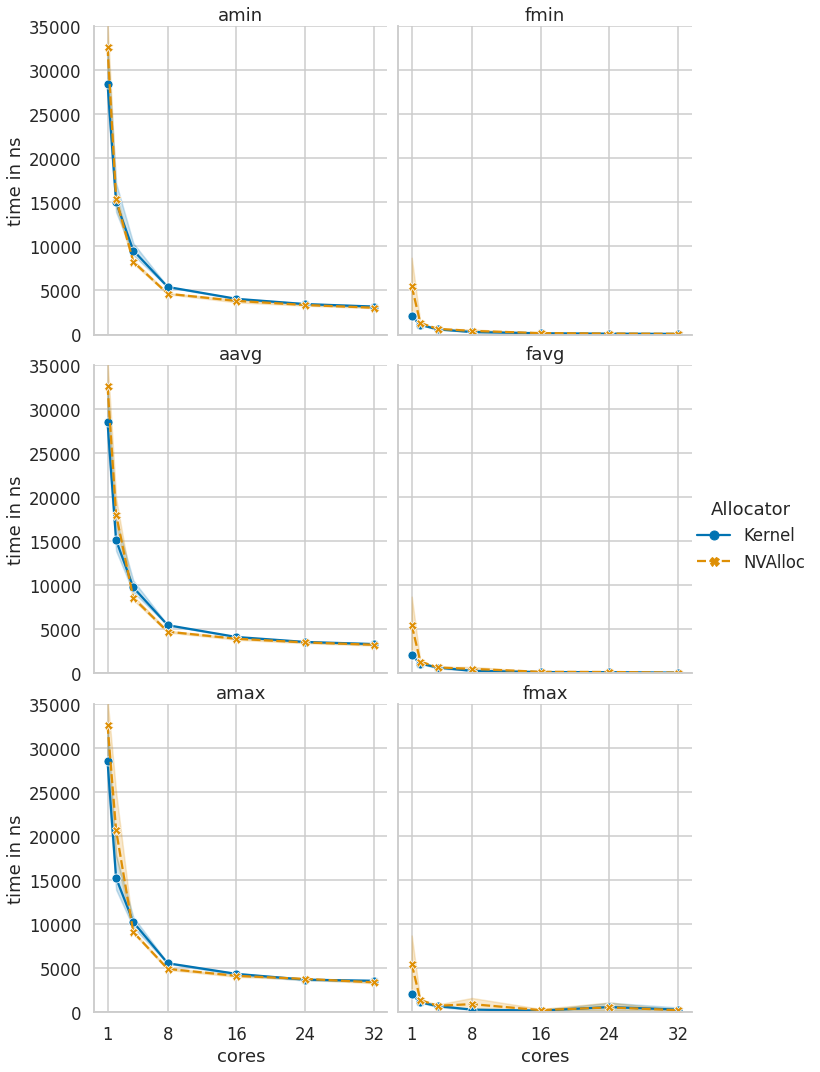

In [3]:
nvalloc_d = pd.read_csv(nvalloc / "out.csv")
nvalloc_d["alloc"] = "NVAlloc"
buddy_d = pd.read_csv(buddy / "out.csv")
buddy_d["alloc"] = "Kernel"


pgd = pd.concat([nvalloc_d, buddy_d], ignore_index=True)
pgd["cores"] = pgd["x"]
pgd = pgd[["cores", "alloc", "amin", "fmin", "aavg", "favg", "amax", "fmax", "iteration"]].melt(
    id_vars=["cores", "alloc", "iteration"],
    value_vars=["amin", "fmin", "aavg", "favg", "amax", "fmax"], value_name="time")
# pgd = pgd.groupby(["cores", "alloc", "variable", "mem"]).min()
order = ["Kernel", "NVAlloc"]
g = sns.relplot(data=pgd, kind="line", x="cores", y="time",
                col="variable", col_wrap=2, style="alloc", hue="alloc", markers=True,
                style_order=order, hue_order=order)
g.set(xticks=[1, 8, 16, 24, 32])
g.set(ylim=(0, 35000))
g.legend.set_title("Allocator")
g.set(ylabel="time in ns")
g.set(xlabel="cores")
g.set_titles("{col_name}")
